In [1]:
import numpy as np
import os
import torch
import torchvision.transforms as T
from PIL import Image, ImageColor
from scipy import ndimage

data_root = './carseg_data-2/arrays'
backgrounds_root = './carseg_data-2/images/landscapes'

In [2]:
parts = {10: {'col': 'orange', 'name':'hood'}, 
         20: {'col':'darkgreen', 'name':'front door'}, 
         30: {'col':'yellow', 'name':'rear door'}, 
         40: {'col':'cyan', 'name':'frame'}, 
         50: {'col':'purple', 'name':'rear quarter panel'}, 
         60: {'col':'lightgreen', 'name':'trunk lid'}, 
         70: {'col':'blue', 'name':'fender'}, 
         80: {'col':'pink', 'name':'bumper'}, 
         90: {'col':'darkgray', 'name':'rest of car'},
         0 : {'col':'black', 'name':'background'}}

def display_car(data_arr):
    # Can take both full data and already split data
    if type(data_arr) == torch.Tensor: data_arr = np.moveaxis(data_arr.numpy().astype(np.uint8), 0, 2)
    elif data_arr.shape[0] == 3: data_arr = np.moveaxis(data_arr.astype(np.uint8), 0, 2)
    elif data_arr.shape[2] > 3: data_arr = data_arr[:,:,:3]
    img = Image.fromarray(data_arr)
    display(img) # img.show() for jupyter
    
def display_labels(data_arr):
    # Can take both full data and already split data
    if type(data_arr) == torch.Tensor: data_arr = data_arr.numpy()
    if data_arr.dtype != np.uint8: data_arr = data_arr.astype(np.uint8)*10
    if data_arr.ndim > 2: data_arr = data_arr[:,:,3]
    img = Image.fromarray(data_arr)
    pixels = list(img.getdata())
    pixels = [ImageColor.getrgb(parts.get(pixel)['col']) for pixel in pixels]
    image = Image.new("RGB", (256, 256), (0,0,0))
    image.putdata(pixels)
    display(image)
    
def numpy_to_tensor(arr):
    return np.moveaxis(arr, 2, 0).astype(np.float32)

def tensor_to_numpy(tens):
    arr = np.moveaxis(tens, 0, 2).astype(np.uint8)
    return arr

In [436]:
def center_square(img):
    """Returns the cropped central square of an image (crops the largest dimension to match the smallest one)"""
    if img.size[0] == img.size[1]: return img
    smallest_dim = np.argmin(img.size)
    largest_dim = np.argmax(img.size)
    square_dim = img.size[smallest_dim]
    crop_dims = [0,0,0,0]
    crop_dims[largest_dim] = int(img.size[largest_dim]/2-square_dim/2)
    crop_dims[largest_dim+2] = int(img.size[largest_dim]/2+square_dim/2)
    crop_dims[smallest_dim] = 0
    crop_dims[smallest_dim+2] = img.size[smallest_dim]
    crop_img = img.crop(crop_dims)
    
    return crop_img

def set_background(car_arr, labels_arr, img):
    """Places all non-0 pixels of the car on the background img"""
    center_img = center_square(img)
    back_arr = np.array(center_img.resize(labels_arr.shape))
    # Use both car and labels just in case
    back_arr[labels_arr!=0] = car_arr[labels_arr!=0]
    
    # In the black car dataset, label pixel count should be similar to non-black pixel count
    if np.sum(car_arr!=0)/3 < np.sum(labels_arr!=0)*1.2:
        # In the black dataset, part of the car isn't correctly labeled, so also use car data for setting background
        back_arr[car_arr!=0] = car_arr[car_arr!=0]
    
    return back_arr

def move_full_car(arr, x, y, angle=0, zoom=1):
    """Moves the center of the car to (x, y). Takes the whole array (car AND labels)"""
    car_idxs = np.where(arr!=0)
    car_bbox = [max(0,np.min(car_idxs[1])-10), max(0,np.min(car_idxs[0])-10), min(255, np.max(car_idxs[1])+10), min(255,np.max(car_idxs[0])+10)]
    # Array with just the car
    car_arr = arr[car_bbox[1]:car_bbox[3],car_bbox[0]:car_bbox[2]]
    # Rotate the car
    car_arr = ndimage.rotate(car_arr, angle, reshape=True, order=0)
    car_arr = ndimage.zoom(car_arr, (zoom, zoom, 1), order=0)
    # Edges of the car in the new array (without taking into account new image borders)
    edges = [y-np.ceil(car_arr.shape[0]/2),y+np.floor(car_arr.shape[0]/2),x-np.ceil(car_arr.shape[1]/2),x+np.floor(car_arr.shape[1]/2)]
    # Where to crop the car if it goes off bounds
    car_limits = [max(0,-1*int(edges[0])), 255-int(edges[1]) if 255-int(edges[1]) < 0 else car_arr.shape[0], max(0,-1*int(edges[2])), 255-int(edges[3]) if 255-int(edges[3]) < 0 else car_arr.shape[1]]
    edges = [max(0,int(edges[0])), min(255, int(edges[1])), max(0,int(edges[2])), min(255, int(edges[3]))]
    
    new_arr = np.zeros(arr.shape)
    new_arr[edges[0]:edges[1],edges[2]:edges[3]] = car_arr[car_limits[0]:car_limits[1],car_limits[2]:car_limits[3]]
    
    return new_arr.astype(np.uint8)

In [622]:
import os
import numpy as np
from torch.utils.data import Dataset
from skimage.transform import resize
from PIL import Image
import random

class CarDataset(Dataset):
    def __init__(self, root, file_list: list=None, background_root: str=None, move_car: bool=False, rotate_car: bool=False, zoom_car: bool=False):
        """
        Initializes the dataset.
        Parameters:
            file_list: a list of filenames from 'root' to use. If not specified, all files will be used.
            background_root: root folder of the background folders. If not specified, no backgrounds will be used.
            move_car: specifies if the cars should be moved to a random location in the image
            rotate_car: specifies if the cars should be given a random rotation (within a range)
        Backgrounds, rotations and translations are random. There is a chance that none will be performed at all.
        This chance is higher for 'photo' images, which will only be rotated/translated when the background is changed (to avoid black bars)
        """
        self.root = root
        self.filenames = os.listdir(self.root) if file_list is None else file_list
        self.background_root = background_root
        if background_root is not None:
            self.backgrounds = [os.path.join(background_root, filename) for filename in os.listdir(background_root)]
        self.move_car = move_car
        self.rotate_car = rotate_car
        self.zoom_car = zoom_car
        
    def __len__(self):
        return len(self.filenames)
        
    def __getitem__(self, index):
        filename = self.filenames[index]
        arr = np.load(os.path.join(self.root, filename))
        photo_mod = True
        if 'photo' in filename: 
            # Photos only get modified with 33% chance. And always get both transforms
            photo_mod = random.randrange(0,3)==1
        # Don't move car with 10% probability
        if self.move_car and random.randrange(0,10)>0 and photo_mod: 
            x = random.randrange(80,255-80)
            y = random.randrange(80,255-80)
            angle = random.randrange(-30,30) if self.rotate_car else 0
            zoom = random.uniform(0.8,1.4) if self.zoom_car else 1
            arr = move_full_car(arr, x, y, angle, zoom)            
        car = arr[:,:,0:3]
        labels = arr[:,:,3]
        if self.background_root is not None and photo_mod:
            rand_idx = random.randrange(0,len(self.backgrounds))
            # Some backgrounds are RGB
            img = Image.open(self.backgrounds[rand_idx]).convert('RGB')
            car = set_background(car, labels, img)
        # Resize function does not work on int dtypes, so we must convert to float before
        car = resize(car.astype(np.float32), (256, 256))
        # Convert to the torch tensor image convention (CxWxH)
        car = np.moveaxis(car, 2, 0)
        
        labels = resize(labels.astype(np.float32), (256, 256))
        
        return torch.tensor(car), torch.tensor(labels/10)

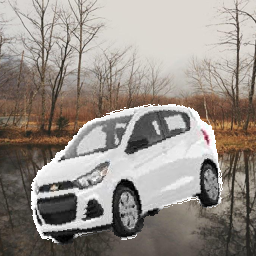

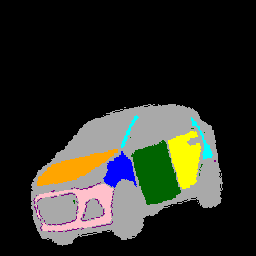

In [651]:
ds = CarDataset(data_root, move_car=True, rotate_car=True, zoom_car=True, background_root=backgrounds_root)
car, labels = ds[-150]
display_car(car)
display_labels(labels)

In [551]:
black_car = []
orange_car = []
photos = []
for file in os.listdir('./carseg_data-2/arrays'):
    if 'orange' in file: orange_car.append(file)
    elif 'black' in file: black_car.append(file)
    elif 'photo' in file: photos.append(file)

print(len(black_car), len(orange_car), len(photos))

834 2001 168


In [573]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

photo_train, photo_test = photos[30:],photos[:30]
black_train, black_test = train_test_split(black_car, test_size=0.2, random_state=42)
orange_train, orange_test = train_test_split(orange_car, test_size=0.2, random_state=42)

joint_train_ds = CarDataset(data_root, photo_train*4+black_train+orange_train,background_root=backgrounds_root, rotate_car=True, move_car=True)
#No data augmentation in the test set
joint_test_ds = CarDataset(data_root, photo_test+black_test+orange_test)
photo_test_ds = CarDataset(data_root, photo_test)
black_test_ds = CarDataset(data_root, black_test)
orange_test_ds = CarDataset(data_root, orange_test)

train_dl = DataLoader(joint_train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(joint_test_ds, batch_size=16)

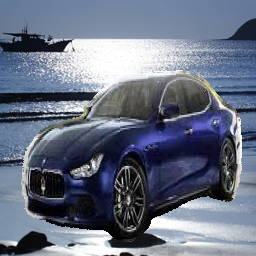

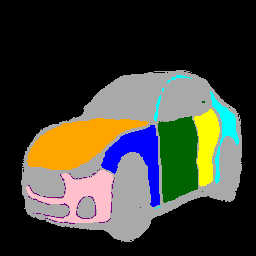

In [621]:
car, labels = joint_train_ds[20]
display_car(car)
display_labels(labels)